# Deep dive into arrival times

In [24]:
import xarray as xr
import pandas as pd
import pyat_tools
from matplotlib import pyplot as plt
from Noise_Interferometry.Modules import inversion
import numpy as np
from scipy import signal
import hvplot.xarray
import scipy
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
fn = '/Volumes/Ocean_Acoustics/CTD Data/Axial_Base_201hr_avg_SSP.nc'
ssps = xr.load_dataarray(fn)

ssps_single_year = ssps[::200,:].loc[pd.Timestamp('2016-01-01'):pd.Timestamp('2017-01-01'),11:1527]

ssp_arlpy = pyat_tools.convert_SSP_arlpy(ssps_single_year.mean('time'), 0)

In [111]:
c0 = ssps_single_year.mean()

ssp = np.ones(len(ssp_arlpy))*c0.values
ssp_arlpy_const = ssp_arlpy
ssp_arlpy_const[:,1] = ssp

In [127]:
# Write Environment File
fn = 'caldera'
pyat_tools.build_env_file(ssp_arlpy,'env_files/caldera_top_mediumsandy.txt','env_files/caldera_bottom_mediumsandy.txt', f'{fn}.env')

# Write field flp file
s_depths=[1527] #meters
ranges =  [3.186] #km
r_depths = [1518] # meters
pyat_tools.write_flp_file(s_depths, ranges, r_depths, fn)

# Build Frequency vector to accurate sample DTFT (so that x(t) can be reconstructed)
Fs = 200
To = 20

t, freq_half, freq_full = pyat_tools.get_freq_time_vectors(Fs, To)

removed .flp
N:	4000
To:	20 [s]
Δf	0.025


In [113]:
# Check that simulation works
os.system(f'kraken.exe {fn}')

0

In [128]:
# Simulate with Kraken
pressures = pyat_tools.simulate_FDGF('caldera', freq_half, [1, 90], krakenc=False, verbose=True)

pt = np.real(scipy.fft.ifft(pressures))
pt_c = np.abs(signal.hilbert(pt))

100%|██████████| 2001/2001 [01:12<00:00, 27.72it/s]


In [129]:
NCCF_sim = pyat_tools.create_NCCF(pt_c)

dA = -1*inversion.calc_prop_time(NCCF_sim, 'dA', tight=False).values
s1b0 = inversion.calc_prop_time(NCCF_sim, 's1b0B', tight=False).values
s2b1 = inversion.calc_prop_time(NCCF_sim, 's2b1B', tight=False).values
s3b2 = inversion.calc_prop_time(NCCF_sim, 's3b2B', tight=False).values


In [130]:
print(dA, s1b0, s2b1, s3b2)

[2.1450038] [2.98427623] [4.6658312] [6.57467697]


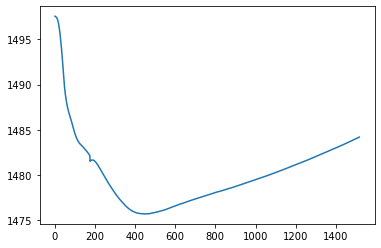

In [131]:
plt.plot(ssp_arlpy[:,1])

In [7]:
import xarray as xr
from Noise_Interferometry.Modules import inversion
from scipy import signal
import numpy as np

In [3]:
fn = '/Volumes/Ocean_Acoustics/NCCFs/MJ03F-MJ03E/6year_NCCF_1.nc'

NCCFs = xr.load_dataarray(fn)

In [4]:
NCCF = NCCFs.mean('dates')

In [29]:
NCCFc = np.expand_dims(np.abs(signal.hilbert(NCCF)),0)

NCCFcx = xr.DataArray(NCCFc, dims=['dates','delay'], coords={'delay':NCCF.delay})

In [30]:
NCCFcx.shape

(1, 11999)

In [31]:
dA = inversion.calc_prop_time(NCCFcx, 'dA')

In [32]:
dA

<xarray.DataArray 'propagation times for dA' (dates: 1)>
array([-2.12077923])
Coordinates:
  * dates    (dates) int64 0